##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Deep Convolutional Generative Adversarial Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/dcgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, see MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Setup

In [1]:
!pip3 install tensorflow==2.4.1
!pip3 install -U tensorflow-quantum

In [34]:
import cirq
import sympy

import tensorflow as tf

import tensorflow_quantum as tfq

from cirq.contrib.svg import SVGCircuit

In [3]:
tf.__version__

'2.4.1'

In [4]:
# # To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-xv2zhaux
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-xv2zhaux
  Using cached protobuf-3.18.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.13.0
    Uninstalling protobuf-3.13.0:
      Successfully uninstalled protobuf-3.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-quantum 0.5.1 requires protobuf==3.13.0, but you have protobuf 3.18.0 which is incompatible.
cirq-google 0.11.0 requires protobuf~=3.13.0, but you have protobuf 3.18.0 which is incompatible.


In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [6]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
noise_dim = 8
noise_dim_bigger = 100

### Load and prepare the dataset

In [8]:
train_images = np.load('/content/drive/My Drive/save-full-cropped-centered.npy')

In [9]:
train_images.shape

(138, 128, 128)

In [10]:
N = train_images.shape[1]

In [11]:
train_images = train_images.reshape(train_images.shape[0], N, N, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [12]:
train_images.shape

(138, 128, 128, 1)

In [13]:
nb_images = train_images.shape[0]

# New Section

In [14]:
BUFFER_SIZE = nb_images
BATCH_SIZE = nb_images // 10
BATCH_SIZE

13

# Circuits

In [15]:
num_qbits = noise_dim
n_blocks = num_qbits//2 * (num_qbits//2 + 1) // 2
symbol = [[sympy.Symbol(f'theta_{l}_{i}') for i in range(15)] for l in range(n_blocks)]

In [64]:
def convert_to_circuit(Z):
    """Encode noise into quantum datapoint."""

    
    qubits = cirq.GridQubit.rect(1, num_qbits)
    circuit = cirq.Circuit()
    for i in range(num_qbits):
        circuit.append(cirq.ry(Z[i]).on(qubits[i]))
    return circuit

def convert_to_tfq_tensor(Z):
    angles = tf.identity(Z)
    return tfq.convert_to_tensor([convert_to_circuit(z_i) for z_i in angles.numpy()])

In [65]:
def create_random_1q_block(circuit, q, symbs):
    circuit += cirq.rz(symbs[0])(q)
    circuit += cirq.ry(symbs[1])(q)
    circuit += cirq.rz(symbs[2])(q)


def create_2q_block(circuit, qubits, block_idx):
    for i, q in enumerate(qubits):
        create_random_1q_block(circuit, q, symbol[block_idx][:3])
        
    circuit += cirq.CX(qubits[1], qubits[0])
     
    circuit += cirq.rz(symbol[block_idx][4])(qubits[0])
        
    circuit += cirq.ry(symbol[block_idx][5])(qubits[1])
    circuit += cirq.CX(qubits[0], qubits[1])
    circuit += cirq.ry(symbol[block_idx][6])(qubits[1])
    circuit += cirq.CX(qubits[1], qubits[0])
    
    for i, q in enumerate(qubits):
        create_random_1q_block(circuit, q, symbol[block_idx][-3:])

def create_quantum_model():
    circuit = cirq.Circuit()
    qubits = cirq.GridQubit.rect(1, num_qbits)
    create_2q_block(circuit, [qubits[3], qubits[4]], 0)
    create_2q_block(circuit, [qubits[2], qubits[3]], 1)
    create_2q_block(circuit, [qubits[4], qubits[5]], 2)
    create_2q_block(circuit, [qubits[1], qubits[2]], 3)
    create_2q_block(circuit, [qubits[3], qubits[4]], 4)
    create_2q_block(circuit, [qubits[5], qubits[6]], 5)
    create_2q_block(circuit, [qubits[0], qubits[1]], 6)
    create_2q_block(circuit, [qubits[2], qubits[3]], 7)
    create_2q_block(circuit, [qubits[4], qubits[5]], 8)
    create_2q_block(circuit, [qubits[6], qubits[7]], 9)

    readouts = [cirq.Z(bit) for bit in qubits]

    return circuit, readouts

model_circuit, model_readout = create_quantum_model()
tfq_model = tfq.layers.PQC(model_circuit, model_readout)

## Create the models

Quantum model

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [66]:
def make_generator_model(quantum_layer: tfq.layers.PQC = None):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(), dtype=tf.string))
    model.add(quantum_layer)
    model.add(layers.Dense(noise_dim_bigger, use_bias=False))
    
    model.add(layers.Dense(64*64*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((64, 64, 256)))
    assert model.output_shape == (None, 64, 64, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #print(model.output_shape)
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 64, 64, 64)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #print(model.output_shape)
    assert model.output_shape == (None, 128, 128, 1)

    return model

Use the (as yet untrained) generator to create an image.

In [67]:
generator = make_generator_model(tfq_model)
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 8)                 90        
_________________________________________________________________
dense_5 (Dense)              (None, 100)               800       
_________________________________________________________________
dense_6 (Dense)              (None, 1048576)           104857600 
_________________________________________________________________
batch_normalization_2 (Batch (None, 1048576)           4194304   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1048576)           0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 128)      

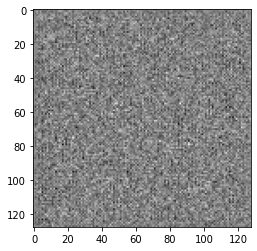

In [70]:

noise = tf.random.normal([1,noise_dim], seed = 42)
noise_cirq = convert_to_tfq_tensor(noise)
generated_image = generator(noise_cirq, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [71]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    
    model.add(layers.Dense(noise_dim_bigger))
    model.add(layers.Dense(noise_dim))
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [72]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[4.513243e-05]], shape=(1, 1), dtype=float32)


In [73]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               26214500  
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [74]:
# hyperparams
dimension_image_alpha = [1] * len(discriminator.input_shape[1:])
gradient_penalty_weight = 10.0
nb_steps_update_critic = 5

### Critic loss



In [75]:
def wasserstein_loss_critic(real_output: tf.Tensor, fake_output: tf.Tensor) -> tf.Tensor:
    """The Wasserstein loss of the discriminator from its output on fake and real data.

    :param real_output: Output of the discriminator when given real data.
    :param fake_output: Output of the discriminator when given fake data from generator.

    :return: Wasserstein loss evaluation for the discriminator

    """
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    return fake_loss - real_loss


### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [76]:
def wasserstein_loss_generator(fake_output: tf.Tensor) -> tf.Tensor:
    """The Wasserstein loss of the generator from the output of the discriminator on fake data.

    :param fake_output: Output of the discriminator when given fake data from generator.

    :return: Cross entropy with Fake/True labels given by discriminator.

    """

    return -tf.reduce_mean(fake_output)

### Loss Penalty

In [77]:


@tf.function
def gradient_penalty(critic:tf.keras.Model, fake_generator_output: tf.Tensor, images: tf.Tensor) -> tf.Tensor:
    """ Penalty from the gradients"""

    alpha = tf.random.uniform(
        [images.shape[0]] + dimension_image_alpha, 0.0, 1.0
    )
    difference_fake_real = fake_generator_output - images
    interpolation = images + (alpha * difference_fake_real)
    with tf.GradientTape() as tape:
        tape.watch(interpolation)
        preds = critic(interpolation, training=True)
    gradients = tape.gradient(preds, [interpolation])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gp = tf.reduce_mean((slopes - 1.0) ** 2)
    return gp


The discriminator and the generator optimizers are different since you will train two networks separately.

In [78]:
lr = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [79]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [80]:
EPOCHS = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [81]:
loss_gen = []
loss_disc = []

In [82]:
@tf.function
def train_generator(gan_instance:tf.keras.Model, critic:tf.keras.Model, noise: tf.Tensor):
    """ Update the generator parameter with its optimizer"""

    with tf.GradientTape() as tape:
        generated_images = gan_instance(noise, training=False)
        fake_output = critic(generated_images, training=True)

        gen_loss = wasserstein_loss_generator(fake_output)

    gradients_of_generator = tape.gradient(
        gen_loss, gan_instance.trainable_variables
    )
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, gan_instance.trainable_variables)
    )

@tf.function
def train_critic(gan_instance:tf.keras.Model, critic:tf.keras.Model, noise: tf.Tensor, images: tf.Tensor):
    """Update the generator parameter with its optimizer

    :param noise: Input of the generator
    :param images: Real images as input for the discriminator.
    """

    with tf.GradientTape() as tape:
        generated_images = gan_instance(noise, training=False)

        real_output = critic(images, training=True)
        fake_output = critic(generated_images, training=True)
        disc_loss = wasserstein_loss_critic(real_output, fake_output)
        penalty_loss = gradient_penalty(critic, generated_images, images)
        disc_loss += penalty_loss * gradient_penalty_weight

    gradients_of_critic = tape.gradient(disc_loss, critic.trainable_variables)
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_critic, critic.trainable_variables)
    )

In [83]:
def train(dataset, epochs):

    noise_cst_for_cirq = tf.random.normal([nb_images, noise_dim], seed = 0)
    noise_cst = convert_to_tfq_tensor(noise_cst_for_cirq)
    train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE * nb_steps_update_critic)

    for epoch in range(epochs):
        start = time.time()

        for image_batch in train_dataset:
            batches_discriminator = tf.data.Dataset.from_tensor_slices(image_batch).batch(BATCH_SIZE)

            for discriminator_batch in batches_discriminator:
                noise_for_cirq = tf.random.normal([discriminator_batch.shape[0], noise_dim])
                noise = convert_to_tfq_tensor(noise_for_cirq)
                train_critic(generator, discriminator, noise, discriminator_batch)
            
            noise_for_cirq = tf.random.normal([BATCH_SIZE, noise_dim])
            noise = convert_to_tfq_tensor(noise_for_cirq)
            train_generator(generator, discriminator, noise)

        
        generated_images = generator(noise_cst, training=False)
        real_output = discriminator(train_images, training=False)
        fake_output = discriminator(generated_images, training=False)

        gen_loss = wasserstein_loss_generator(fake_output)
        disc_loss = wasserstein_loss_critic(real_output, fake_output)

        loss_gen.append(gen_loss.numpy())
        loss_disc.append(disc_loss.numpy())

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

**Generate and save images**


In [86]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).

    test_input_tf = convert_to_tfq_tensor(test_input)
    predictions = model(test_input_tf, training=False)

    fig = plt.figure(figsize=(16, 16))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

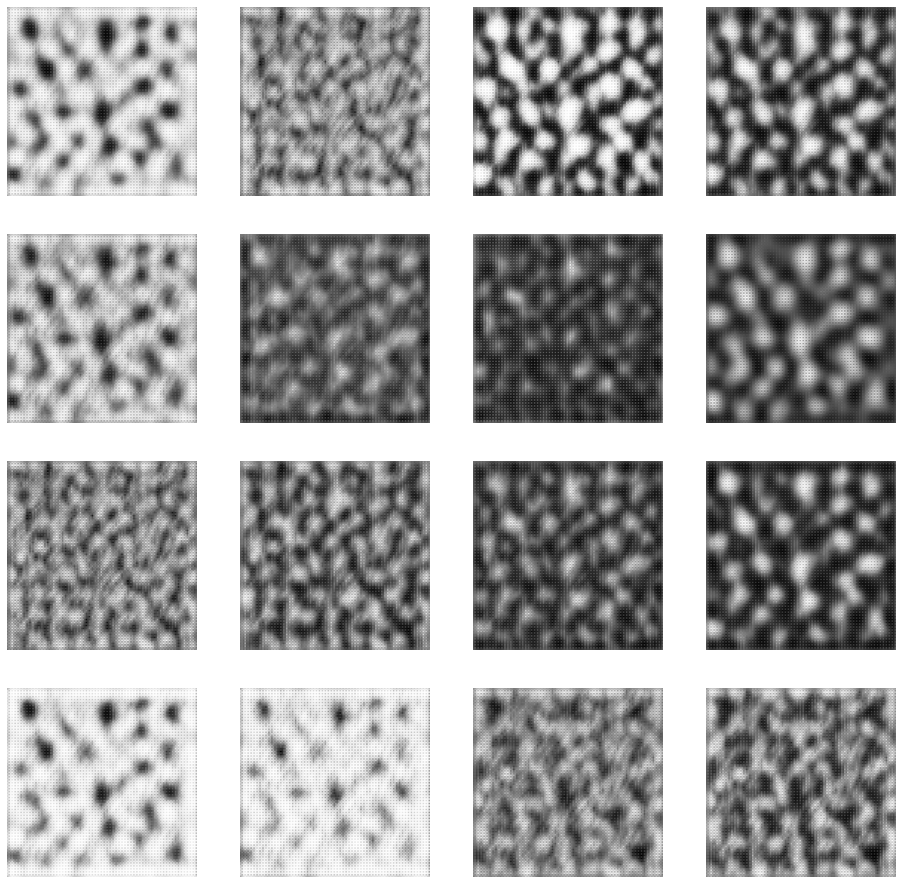

In [87]:
train(train_images, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [88]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

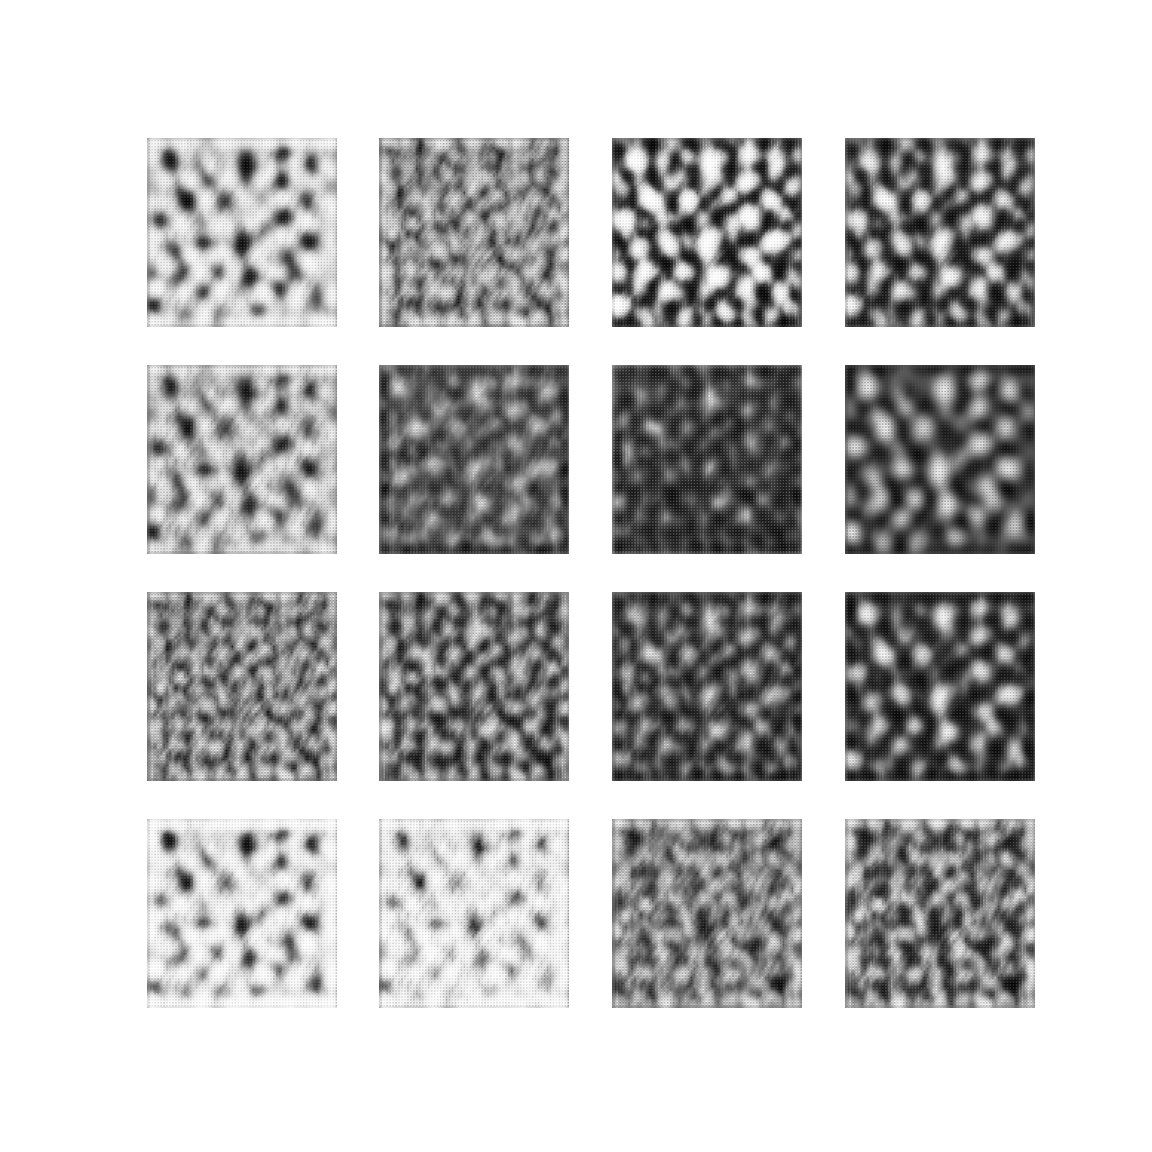

In [89]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [90]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [91]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

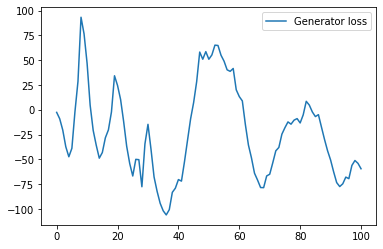

In [94]:
plt.plot(list(range(len(loss_gen))), loss_gen, label='Generator loss')
plt.legend()
plt.show()

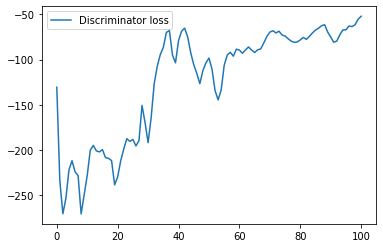

In [95]:
plt.plot(list(range(len(loss_disc))), loss_disc, label='Discriminator loss')
plt.legend()
plt.show()

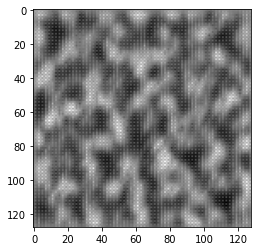

In [97]:
generated_image = generator(noise_cirq, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')